In this notebook we try tro reproduce the baseline plot and primary metric, using sklearn. The final conclusion is that this is not the file that has been used to create the plot we are familiar with.

Message on September 16th
Mark_baseline_virtual_telescope_ED.ipynb is the file that I had here updated to images 512x512 and to the yrs range 2011-2015, obtaining as result a plot very different from what we had in the final presentation. I realized today the results of this file has never been used to produce the c.l. plot we presented (and that is now in the paper). The plot we are familiar with has been rather produced from the predictions of the model mark_linear_l1loss, that are saved in the virtual telescope results folder. The code used to obtain those predictions is not committed  but from what I see in the results I understand a linear model had been implemented and added to the virtual telescope pipeline, meaning it used the Adam optimizer.  The origin of the difference is probably that:  sklearn linear regression do not use any optimizer and it rather solves by method of ordinary least squares the regression problem, this can explain why the results were similar in the middle intensity range but screwed up completely at the extremes were there are less data points and were numeric values are much smaller.

In [78]:
import sys
sys.path.append("/gpfs/gpfs_gl4_16mb/b9p111/b9p111ai/expanding-sdo-capabilities/src")
import torch
import numpy as np
import sdo
import logging
from sdo.datasets.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from sdo.metrics.azimuth_metric import azimuthal_average, compute_2Dpsd
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import mean_squared_error

In [3]:
def data_loader_to_XY(data_loader,verbose=False):
    start = time.time()
    data = []
    for batch_index, batch in enumerate(data_loader):
        end = time.time()
        if verbose:
            print("batch{0:03d} loading took: ".format(batch_index), end-start)
        data.append(batch.cpu())
        start = time.time()
    d = np.vstack([d.numpy() for d in data])
    #print(d.shape)
    #n_channels = d.shape[1]
    xtemp = d[:,0:3,:,:].transpose([0,2,3,1])
    # We assume the last channel loaded is the prediction target Y

    ytemp = d[:,-1,:,:]
    shape = xtemp.shape
    X = xtemp.reshape(shape[0]*shape[1]*shape[2],shape[3])
    Y = ytemp.reshape(shape[0]*shape[1]*shape[2])
    print(X.shape, Y.shape)
    return X, Y

def init_gpu(cuda_device=None):
    """ Use the GPU. """
    torch.backends.cudnn.enabled = True
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available! Unable to continue")
    if cuda_device is None:
        # Randomly keep trying available GPU devices.
        devices = np.random.permutation(list(range(torch.cuda.device_count())))
        success = False
        for cuda_device in devices:
            _logger.info('Trying to use CUDA device {}...'.format(cuda_device))
            try:
                device = torch.device("cuda:{}".format(cuda_device))
                torch.cuda.set_device(device)
                success = True
                break
            except Exception as error:
                _logger.exception(error)
            if not success:
                raise Exception("No CUDA device is available!")
    else:
        device = torch.device("cuda:{}".format(cuda_device))
        torch.cuda.set_device(device)

    _logger.info("Using device {} for training, current device: {}, total devices: {}".format(device, torch.cuda.current_device(), torch.cuda.device_count()))
    return device  

In [4]:
#Logger and CUDA prelims
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")
torch.backends.cudnn.enabled = True
cuda_device = init_gpu()
print(cuda_device)
print("Using device {} for training, current device: {}, total devices: {}".format(cuda_device, torch.cuda.current_device(), torch.cuda.device_count()))
 

[2019-09-16 03:35:02] INFO:__main__:Trying to use CUDA device 1...
[2019-09-16 03:35:02] INFO:__main__:Using device cuda:1 for training, current device: 1, total devices: 4
cuda:1
Using device cuda:1 for training, current device: 1, total devices: 4


## 2011 -2013 512x512

In [5]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA','AIA']
channels = ['0094','0171','0193','0211']
input_channels = len(channels)- 1

In [6]:
# Load data
train_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2013], 
                         #mnt_step=1, day_step=1, h_step=24, min_step=60, 
                         subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)
test_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2013], 
                        #mnt_step=1, day_step=1, h_step=24, min_step=60,
                        subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True)

[2019-09-16 03:35:03] INFO:sdo.datasets.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOMLmm"
[2019-09-16 03:35:03] INFO:sdo.datasets.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Timestamps requested values: 
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Years: 2011,2012,2013
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Hours: 0,6,12,18
[2019-09-16 03:35:03] DEBUG:sdo.datasets.sdo_dataset:Minutes: 0
[2019-09-16 03:35:03] INFO:sdo.datasets.sdo_dataset:Max number of timestamps: 2604
[2019-09-16 03:35:06] INFO:sdo.datasets.sdo_dataset:Timestamps found in the inventory: 2449 (0.94)
[2019-09-16 03:35:07] INFO:sdo.datasets.sdo_dataset:N timestamps discarded because channel is missing = 

In [7]:
#Training and testing data
Xtrain, Ytrain = data_loader_to_XY(train_data_loader)
Xtest, Ytest   = data_loader_to_XY(test_data_loader)

(640155648, 3) (640155648,)
(267911168, 3) (267911168,)


In [8]:
# Initialize model
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
model = LinearRegression()
# Train model
model.fit(Xtrain,Ytrain)
# Generate model predictions
Ypred = model.predict(Xtest)
img_pred = Ypred.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)
img_test = Ytest.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)

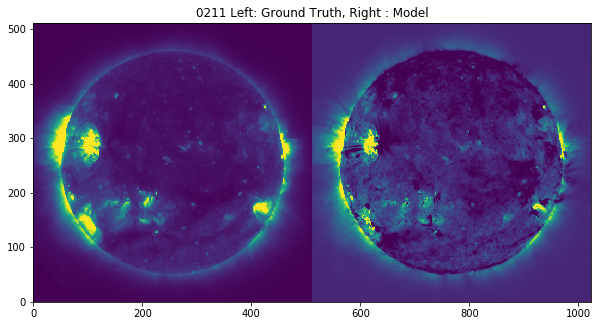

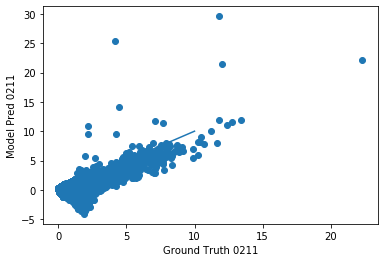

In [10]:
#Show comparison for some image picked from the test set
comp = 12
plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((img_test[comp,:,:],img_pred[comp,:,:]),axis=1),clim=(0,2),origin='lower')
plt.title('{0:s} Left: Ground Truth, Right : Model'.format(channels[-1]))
plt.show()
plt.scatter(img_test[comp,:,:],img_pred[comp,:,:])
plt.xlabel('Ground Truth {0:s}'.format(channels[-1]))
plt.ylabel('Model Pred {0:s}'.format(channels[-1]))
plt.plot([0,10],[0,10])

[2019-09-16 03:44:58] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10013aaca278>
[2019-09-16 03:44:58] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 03:44:58] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10013aaca278>
[2019-09-16 03:44:58] DEBUG:matplotlib.colorbar:Setting pcolormesh


/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'Logarithm of the ground truth intensity')

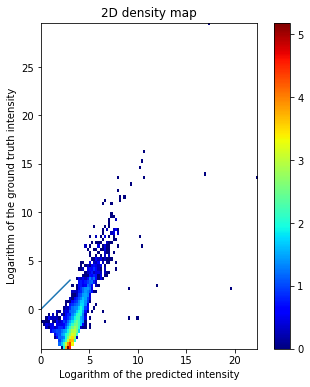

In [12]:
#Plotting a 2D histogram for the ground truth and the predicted image
plt.figure(figsize=(6,6))
H, xedges, yedges = np.histogram2d(img_test[comp,:,:].flatten(), img_pred[comp,:,:].flatten(), bins=100)
plt.imshow(np.log10(H/1.), origin='lower',
          extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()),cmap='jet')
plt.plot([xedges.min(),3],[xedges.min(),3])
plt.colorbar()
plt.title("2D density map")
plt.xlabel('Logarithm of the predicted intensity')
plt.ylabel('Logarithm of the ground truth intensity')

[2019-09-16 03:45:15] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x100147818630>
[2019-09-16 03:45:15] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 03:45:15] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x100147818630>
[2019-09-16 03:45:15] DEBUG:matplotlib.colorbar:Setting pcolormesh


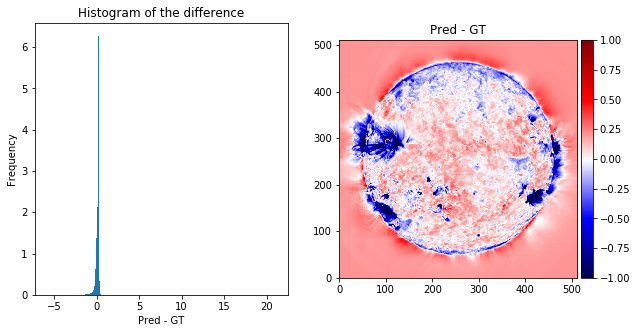

In [13]:
#The snippet below plots the histogram of the fi
fig, axs =plt.subplots(1,2,figsize=(10,5),facecolor='w', edgecolor='k')
axs=axs.ravel()
axs[0].hist((img_pred[comp,:,:]-img_test[comp,:,:]).ravel(),density=True,bins=500)
axs[0].set_title('Histogram of the difference')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Pred - GT')
im1=axs[1].imshow((img_pred[comp,:,:]-img_test[comp,:,:]),cmap='seismic',vmin=-1,vmax=1,origin='lower')
axs[1].set_title('Pred - GT')
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)


In [22]:
def metric_SSIM(output, gt_output):
    """ This is a new metric as per the latest discussions
    to implement the structural similarity index (SSIM) along
    with root MSE.
    """
    prediction = output #has to be a 2D image
    ground_truth = gt_output #has to be a 2D image.
    primary_metric2 = (np.sqrt(mean_squared_error(prediction,ground_truth)) +
                     (1 - abs(ssim(prediction,ground_truth))))/2
    return primary_metric2

In [23]:
nsteps=1022
primary_metric_ssim=np.zeros(nsteps)
for index in range(dim_test[0]):
    primary_metric_ssim[index] = metric_SSIM(img_pred[index,:,:], img_test[index,:,:])    

Text(0.5, 1.0, 'Primary metric (SSIM)')

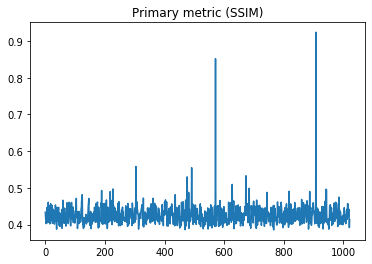

In [24]:
plt.plot(primary_metric_ssim)
plt.title("Primary metric (SSIM)")

In [25]:
# this is the primary metric for 512x512 images 2011-2013, default values for the dataset
# mnt_step=1, day_step=1, h_step=6, min_step=60 (1 image every 6 hours)
primary_metric_ssim.mean()

0.4261461974043382

In [84]:
def plot_histogram(Y_test, Y_pred, mask_by_confidence=False, title='Model', savefig=None, clower=-8):
    H, xedges, yedges = np.histogram2d(np.log10(Y_test.flatten()), 
                                       np.log10(Y_pred.flatten()), 
                                       bins=200, range=[[-3,3.0],[-3,3.0]], normed=False)
    Hnorm = H/H.sum()

    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot([-3,3],[-3,3], linewidth=3)
    plt.title(title, fontsize=20)
    divider = make_axes_locatable(ax)
    im = ax.imshow(np.log10(Hnorm.T+1e-20), origin='lower', clim=(clower,0), 
               extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()),
               cmap='jet', aspect='equal', interpolation='none')
    cax = divider.append_axes('right', size='5%', pad=0.07)
    ax.set_xlabel('Log10 Real Intensity',fontsize=20)
    ax.set_ylabel('Log10 Predicted Intensity', fontsize=20)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    Hcum = Hnorm.copy()
    for i in range(Hnorm.shape[1]):
        Hcum[:,i]=H[:,i].cumsum(axis=0)/H[:,i].sum()
    Hcum[np.where(np.isnan(Hcum))] = 1.0
    mask = np.ones(Hcum.shape)
    mask[np.where(np.abs(Hcum-0.5) <= 0.45)] = np.nan
    if mask_by_confidence:
        ax.imshow(mask.T,extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()),
               origin='lower', cmap='binary', alpha=1.0)
    plt.tick_params(axis='both', which='major', size=15)
    if savefig == None:
        plt.show()
    else:
        plt.savefig(savefig)

/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


[2019-09-16 03:54:53] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10014f4cf978>
[2019-09-16 03:54:53] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 03:54:53] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10014f4cf978>
[2019-09-16 03:54:53] DEBUG:matplotlib.colorbar:Setting pcolormesh
[2019-09-16 03:54:53] DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
[2019-09-16 03:54:53] DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
[2019-09-16 03:54:53] DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[2019-09-16 03:54:53] DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold 

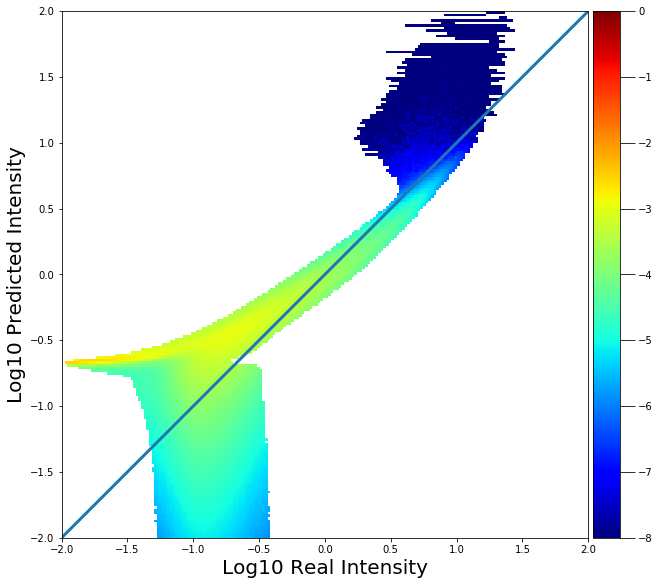

In [27]:
plot_dir = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/results/plots/'
model = 'baseline_512x512_11-13_step_6hrs'
img_file = '2dhist_{}.png'.format(model)
img_file = plot_dir + img_file

plot_histogram(Ytest, Ypred, mask_by_confidence=True, title='', savefig=img_file)

## 2011-2015 512 x512

In [28]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA','AIA']
channels = ['0094','0171','0193','0211']
input_channels = len(channels)- 1

# Load data
train_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2015], 
                         mnt_step=1, day_step=1, h_step=6, min_step=60, 
                         subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)
test_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2015], 
                        mnt_step=1, day_step=1, h_step=6, min_step=60, 
                        subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True)

[2019-09-16 04:02:37] INFO:sdo.datasets.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOMLmm"
[2019-09-16 04:02:37] INFO:sdo.datasets.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Timestamps requested values: 
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Years: 2011,2012,2013,2014,2015
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Hours: 0,6,12,18
[2019-09-16 04:02:37] DEBUG:sdo.datasets.sdo_dataset:Minutes: 0
[2019-09-16 04:02:37] INFO:sdo.datasets.sdo_dataset:Max number of timestamps: 4340
[2019-09-16 04:02:41] INFO:sdo.datasets.sdo_dataset:Timestamps found in the inventory: 4079 (0.94)
[2019-09-16 04:02:42] INFO:sdo.datasets.sdo_dataset:N timestamps discarded because channel is 

In [29]:
Xtrain, Ytrain = data_loader_to_XY(train_data_loader)
Xtest, Ytest   = data_loader_to_XY(test_data_loader)

(1067450368, 3) (1067450368,)
(451936256, 3) (451936256,)


In [30]:
model = LinearRegression()
# Train model
model.fit(Xtrain,Ytrain)
# Generate model predictions
Ypred = model.predict(Xtest)
img_pred = Ypred.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)
img_test = Ytest.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)

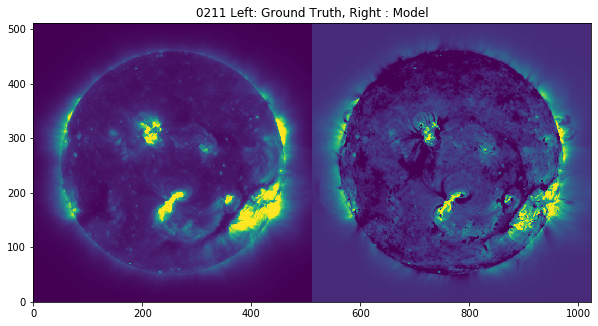

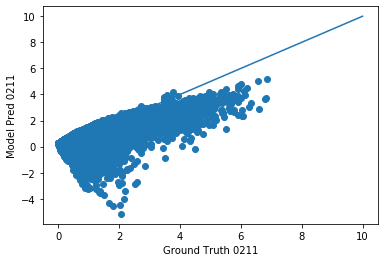

In [31]:
comp = 12
plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((img_test[comp,:,:],img_pred[comp,:,:]),axis=1),clim=(0,2),origin='lower')
plt.title('{0:s} Left: Ground Truth, Right : Model'.format(channels[-1]))
plt.show()
plt.scatter(img_test[comp,:,:],img_pred[comp,:,:])
plt.xlabel('Ground Truth {0:s}'.format(channels[-1]))
plt.ylabel('Model Pred {0:s}'.format(channels[-1]))
plt.plot([0,10],[0,10])

[2019-09-16 04:17:50] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10014f7e8240>
[2019-09-16 04:17:50] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 04:17:50] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10014f7e8240>
[2019-09-16 04:17:50] DEBUG:matplotlib.colorbar:Setting pcolormesh


/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'Logarithm of the ground truth intensity')

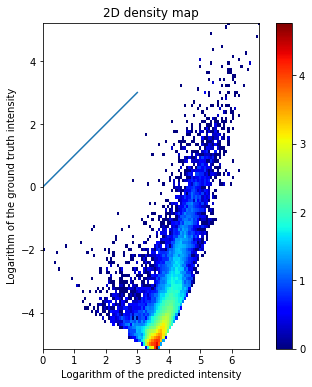

In [33]:
#Plotting a 2D histogram for the ground truth and the predicted image
plt.figure(figsize=(6,6))
H, xedges, yedges = np.histogram2d(img_test[comp,:,:].flatten(), img_pred[comp,:,:].flatten(), bins=100)
plt.imshow(np.log10(H/1.), origin='lower',
          extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()),cmap='jet')
plt.plot([xedges.min(),3],[xedges.min(),3])
plt.colorbar()
plt.title("2D density map")
plt.xlabel('Logarithm of the predicted intensity')
plt.ylabel('Logarithm of the ground truth intensity')

[2019-09-16 04:17:57] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1001765c4550>
[2019-09-16 04:17:57] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 04:17:57] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1001765c4550>
[2019-09-16 04:17:57] DEBUG:matplotlib.colorbar:Setting pcolormesh


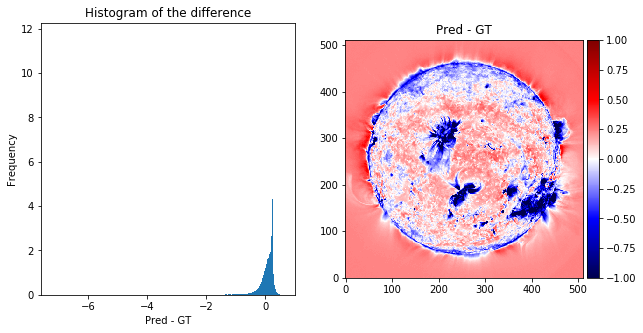

In [34]:
#The snippet below plots the histogram of the fi
fig, axs =plt.subplots(1,2,figsize=(10,5),facecolor='w', edgecolor='k')
axs=axs.ravel()
axs[0].hist((img_pred[comp,:,:]-img_test[comp,:,:]).ravel(),density=True,bins=500)
axs[0].set_title('Histogram of the difference')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Pred - GT')
im1=axs[1].imshow((img_pred[comp,:,:]-img_test[comp,:,:]),cmap='seismic',vmin=-1,vmax=1,origin='lower')
axs[1].set_title('Pred - GT')
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

In [40]:
nsteps=img_test.shape[0]
primary_metric_ssim=np.zeros(nsteps)
for index in range(img_test.shape[0]):
    primary_metric_ssim[index] = metric_SSIM(img_pred[index,:,:], img_test[index,:,:])    

Text(0.5, 1.0, 'Primary metric (SSIM)')

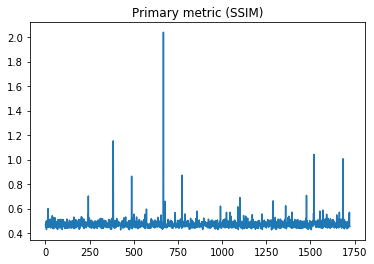

In [41]:
plt.plot(primary_metric_ssim)
plt.title("Primary metric (SSIM)")

In [42]:
# this is the primary metric for 512x512 images 2011-2015, default values for the dataset
# mnt_step=1, day_step=1, h_step=6, min_step=60 (1 image every 6 hours)
primary_metric_ssim.mean()

0.4749975341583903

/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


[2019-09-16 05:26:53] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x100172cc7940>
[2019-09-16 05:26:53] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 05:26:53] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x100172cc7940>
[2019-09-16 05:26:53] DEBUG:matplotlib.colorbar:Setting pcolormesh


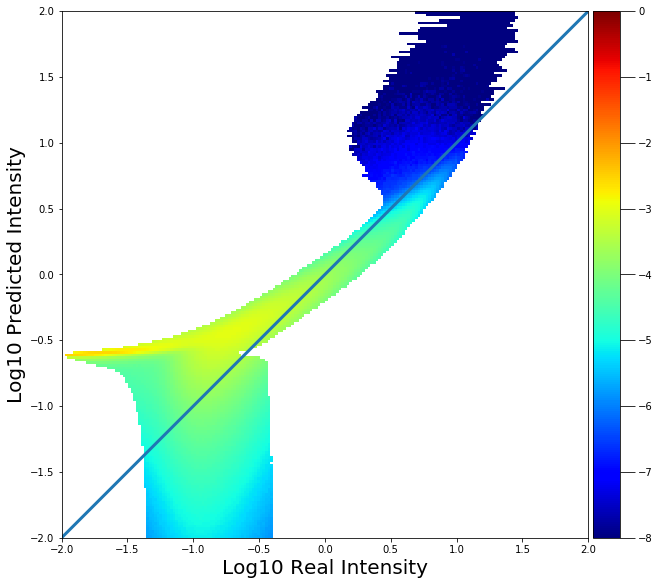

In [53]:
plot_dir = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/results/plots/'
model = 'baseline_512x512_11-15_step_6hrs'
img_file = '2dhist_{}.png'.format(model)
img_file = plot_dir + img_file

plot_histogram(Ytest, Ypred, mask_by_confidence=True, title='', savefig=img_file)

## Loading predictions

The model above does not iterate over epochs. This is unfair. The model below has been trained with 512x512 images, one image every 6 hours BUT 2011, 2012.

In [54]:
home = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/'
path_linear_results = '/pipeline_results_vt/experiments_results_vt/mark_linear_l1loss/0500_mark_linear_l1loss_test_predictions.npy'

In [55]:
Y = np.load(home + path_linear_results)
shape = Y.shape
Y_test = Y[:,:,0:int(shape[2]/2),:]
Y_pred = Y[:,:,int(shape[2]/2):,:]

/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


[2019-09-16 06:26:21] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10016dff8d68>
[2019-09-16 06:26:21] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-09-16 06:26:21] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x10016dff8d68>
[2019-09-16 06:26:21] DEBUG:matplotlib.colorbar:Setting pcolormesh


/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


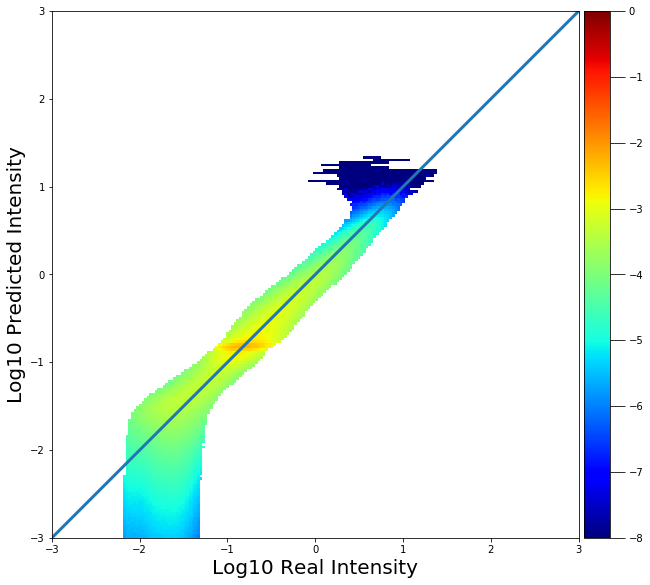

In [85]:
plot_dir = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/results/plots/'
model = 'baseline_512x512_11-15_step_6hrs_500epochs_lowbound3'
img_file = '2dhist_{}.png'.format(model)

plot_histogram(Y_test,Y_pred, mask_by_confidence=True, title='', savefig=img_file)

In [57]:
Y_test.shape

(667, 1, 512, 512)

In [61]:
nsteps=Y_test.shape[0]
primary_metric_ssim=np.zeros(nsteps)
for index in range(Y_test.shape[0]):
    primary_metric_ssim[index] = metric_SSIM(Y_pred[index,0,:,:], Y_test[index,0,:,:])    

Text(0.5, 1.0, 'Primary metric (SSIM)')

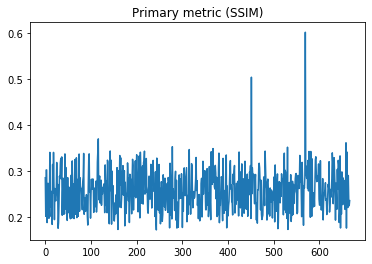

In [62]:
plt.plot(primary_metric_ssim)
plt.title("Primary metric (SSIM)")

In [63]:
primary_metric_ssim.mean()

0.25874679795027217

In [64]:
def metric_RMSE(output, gt_output):
    """ This is a new metric as per the latest discussions
    to implement the structural similarity index (SSIM) along
    with root MSE.
    """
    prediction = output #has to be a 2D image
    ground_truth = gt_output #has to be a 2D image.
    rmse = np.sqrt(mean_squared_error(prediction,ground_truth))
    return rmse

In [65]:
nsteps=Y_test.shape[0]
rmse=np.zeros(nsteps)
for index in range(Y_test.shape[0]):
    rmse[index] = metric_RMSE(Y_pred[index,0,:,:], Y_test[index,0,:,:])    

Text(0.5, 1.0, 'rmse')

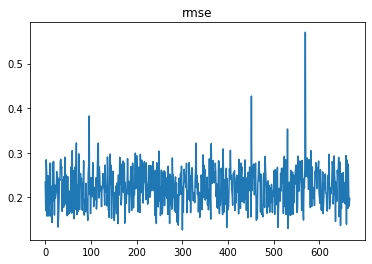

In [66]:
plt.plot(rmse)
plt.title("rmse")

In [67]:
rmse.mean()

0.22251892478569693

In [79]:
def metric_SSIM(output, gt_output):
    """ This is a new metric as per the latest discussions
    to implement the structural similarity index (SSIM) along
    with root MSE.
    """
    prediction = output #has to be a 2D image
    ground_truth = gt_output #has to be a 2D image.
    metric = (1 - abs(ssim(prediction,ground_truth)))
    return metric

Text(0.5, 1.0, 'ssim')

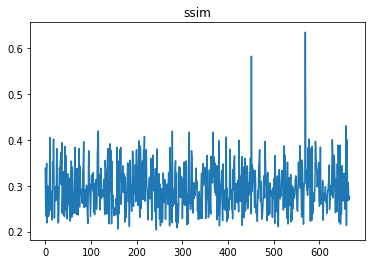

In [80]:
nsteps=Y_test.shape[0]
results_ssim=np.zeros(nsteps)
for index in range(Y_test.shape[0]):
    results_ssim[index] = metric_SSIM(Y_pred[index,0,:,:], Y_test[index,0,:,:])   
plt.plot(results_ssim)
plt.title("ssim")

In [81]:
results_ssim.mean()

0.2949746711148474